In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input as resnet50v2_preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input, ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
""" Dataset directories """
train_data_dir = "Dataset/Preprocessed/Tomato/train_set"
test_data_dir = "Dataset/Preprocessed/Tomato/test_set"

In [16]:
""" Get the first image from the healthy directory """
first_image_file = os.listdir(f"{train_data_dir}/healthy")[0]
img = plt.imread(f"{train_data_dir}/healthy/{first_image_file}")

img_height, img_width, _ = img.shape

img_size = min(img_height, img_width)

print(f"Image size: {img_height}x{img_width} -> {img_size}")

Image size: 400x400 -> 400


In [17]:
""" Set batch size """
batch_size = 16

In [18]:
""" Data augmentation and preprocessing """
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)

Found 21723 images belonging to 5 classes.
Found 5445 images belonging to 5 classes.


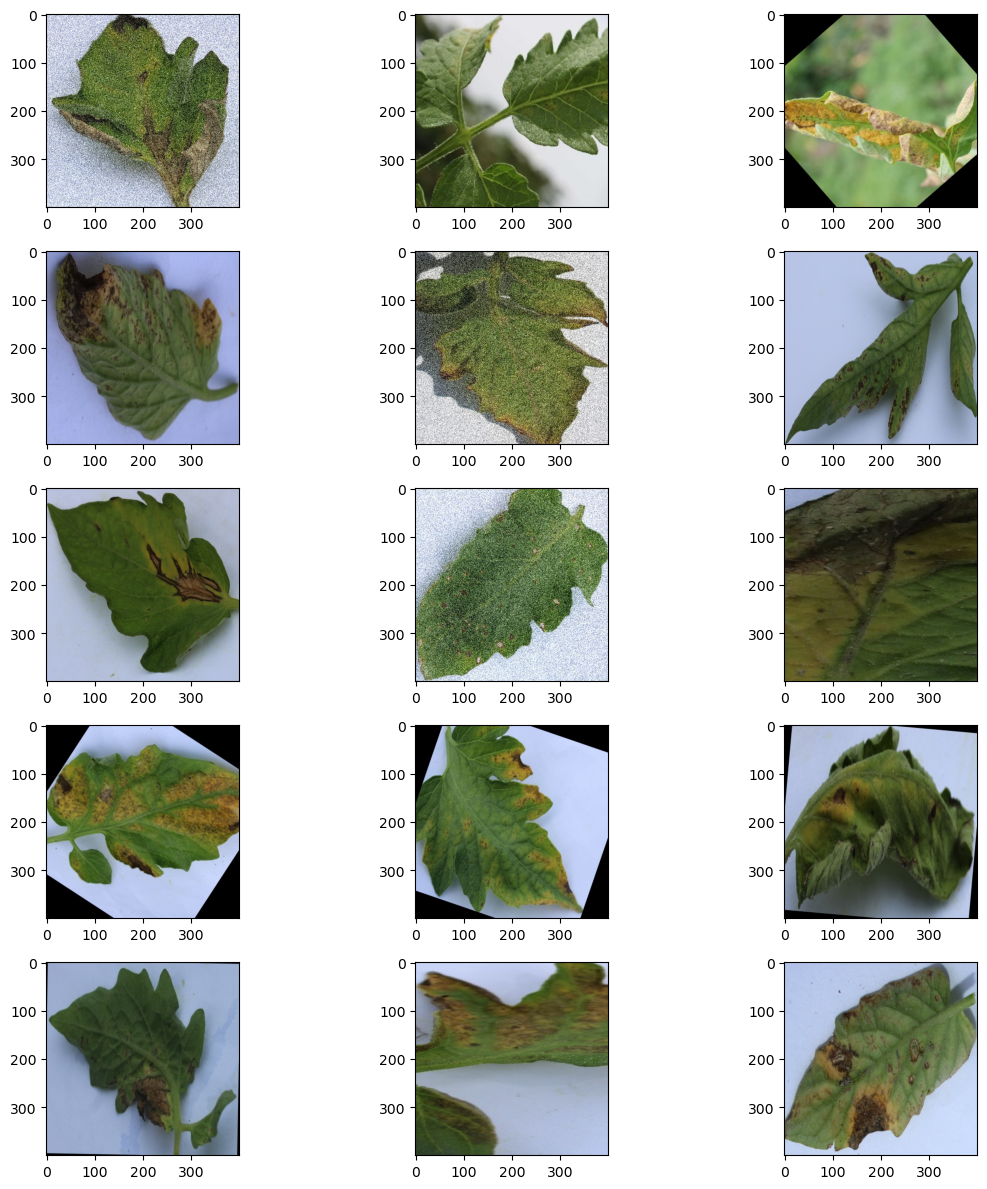

In [19]:
""" Display sample images """
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [20]:
""" Number of classes """
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [21]:
def SamplesPerClass(dir_path):
    num_samples = []
    class_labels = os.listdir(dir_path)
    for class_label in class_labels:
        class_dir = os.path.join(train_data_dir, class_label)
        if os.path.isdir(class_dir):
            num_samples.append(len(os.listdir(class_dir)))
    return np.array(num_samples)

num_samples = SamplesPerClass(train_data_dir)
total_samples = np.sum(num_samples)
class_frequencies = num_samples / total_samples
inverse_class_frequencies = 1 / class_frequencies
class_weights = inverse_class_frequencies / np.sum(inverse_class_frequencies)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

class_weights_dict

{0: 0.3106781363030128,
 1: 0.11949159088577416,
 2: 0.3031006207834271,
 3: 0.06629214473551963,
 4: 0.2004375072922663}

In [22]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.8, min_lr=0.00001)

#### Training ResNet-50 model


In [23]:
""" Load ResNet50V2 model """
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

""" Freeze the base model """
for layer in base_resNet_model.layers:
    layer.trainable = False
    
""" Add custom layers """
x = base_resNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

""" Create model """
resnet_model = Model(inputs=base_resNet_model.input, outputs=predictions)

""" Compile model """
resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [24]:
""" Train model """
resNet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    class_weight=class_weights_dict,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
1357/1357 [==============================] - 107s 75ms/step - loss: 0.1597 - accuracy: 0.4962 - val_loss: 0.9421 - val_accuracy: 0.6178
Epoch 2/200
1357/1357 [==============================] - 91s 67ms/step - loss: 0.1260 - accuracy: 0.5888 - val_loss: 0.8401 - val_accuracy: 0.6581
Epoch 3/200
1357/1357 [==============================] - 92s 67ms/step - loss: 0.1127 - accuracy: 0.6198 - val_loss: 0.7211 - val_accuracy: 0.7107
Epoch 4/200
1357/1357 [==============================] - 91s 67ms/step - loss: 0.1039 - accuracy: 0.6512 - val_loss: 0.7331 - val_accuracy: 0.6987
Epoch 5/200
1357/1357 [==============================] - 92s 68ms/step - loss: 0.0941 - accuracy: 0.6817 - val_loss: 0.6142 - val_accuracy: 0.7599
Epoch 6/200
1357/1357 [==============================] - 92s 68ms/step - loss: 0.0875 - accuracy: 0.7013 - val_loss: 0.5353 - val_accuracy: 0.7978
Epoch 7/200
1357/1357 [==============================] - 92s 68ms/step - loss: 0.0790 - accuracy: 0.7252 - val_loss: 

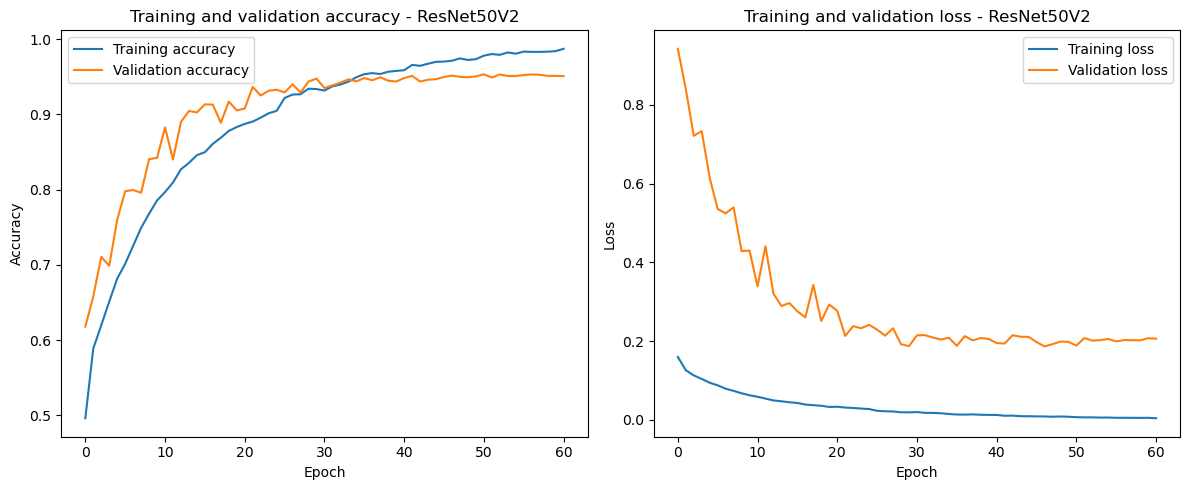

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

""" Plot training and validation accuracy """
axs[0].plot(resNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - ResNet50V2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

""" Plot training and validation loss """
axs[1].plot(resNet_history.history["loss"], label="Training loss")
axs[1].plot(resNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - ResNet50V2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [26]:
""" Save model """
resnet_model.save("Models/resNet_model.h5")

""" Save history """
with open("Models/resNet_history.pkl", "wb") as f:
    pkl.dump(resNet_history.history, f)

c:\ProgramData\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [27]:
""" Evaluate model """
score = resnet_model.evaluate(test_generator)

print(f"Test loss: {score[0]:.3f}")
print(f"Test accuracy: {score[1]:.3f}")

341/341 [==============================] - 20s 57ms/step - loss: 0.1889 - accuracy: 0.9530
Test loss: 0.189
Test accuracy: 0.953
